# Guitar Image Classification


### This notebook is part of the AiLab School AI cours. Contains the code to train a model to classify guitar images, part of the final project of the course.3

The dataset used in this project is derivated from the publication Fuzzy Edge-Detection as a Preprocessing Layer in Deep Neural Networks for Guitar Classification, contains images of 6 different guitar types.

<li>Acoustic</li>
<li>Double Cut</li>
<li>Single Cut</li>
<li>S-Style</li>
<li>T-Style</li>
<li>Ukulele</li>
The dataset was created from a web search and contains 900 images of each guitar type. The images were resized to 224x224 pixel.


In [4]:
# Tensorflow imports for CNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils import ProcessingUtils
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [5]:
# check if gpus are available to tensorflow
print("Num GPUs Available: ", len(
    tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(
    tf.config.experimental.list_physical_devices('CPU')))

print('='*90)
# check gpus specs with nvidia-smi
!nvidia-smi


Num GPUs Available:  1
Num CPUs Available:  1
Tue Apr 25 17:04:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
| 42%   35C    P8               36W / 480W|  23303MiB / 24564MiB |      6%      Default |
|                                         |                      |                  N/A |
+---------------------

In [6]:
# Load the dataset
DATA_PATH = "Y://Datasets//CGD//CGD_no_split//"
CLASES = {
    0: "Acoustic",
    1: "Double_cut",
    2: "Single_cut",
    3: "S_style",
    4: "T_style",
    5: "Ukulele",
}
class_idx = [0, 1, 2, 3, 4, 5]
class_idx = [str(i) for i in class_idx]
# X,y = ProcessingUtils.load_dataset(path=DATA_PATH, classes=class_idx, img_size=(224, 224), shuffle=True, seed=1313, verbose=True)
X, y = ProcessingUtils.load_dataset(
    path=DATA_PATH,
    classes=class_idx,
    img_size=(150, 150),
    shuffle=True,
    seed=1313,
    verbose=True,
)

Loading class 0 ...
Loading class 1 ...
Loading class 2 ...
Loading class 3 ...
Loading class 4 ...
Loading class 5 ...


### Data analysys


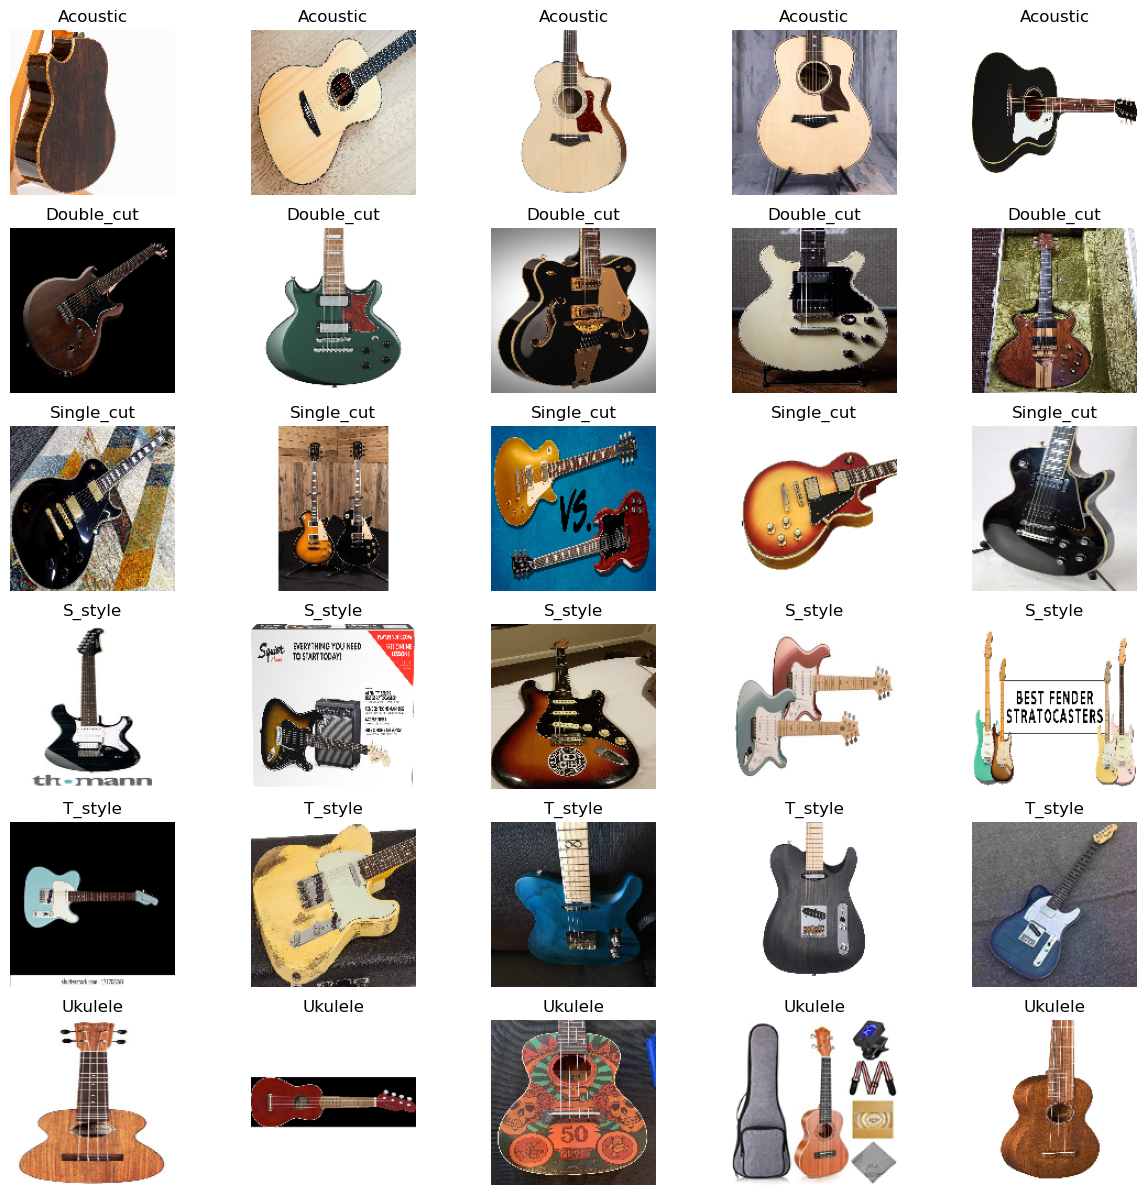

In [7]:
ProcessingUtils.sample_dataset(X, y, CLASES, n=5)

#### Observations

As que can apreciate, the dataset contains noise (images that contain items besides guitars), and images that are not centered in the guitar. This can be a problem for the model training.
The dataset is balanced, contains 900 images of each guitar type.
The guitar styles (cathegories) present similarities with other styles, for example, the acoustic guitar is similar to the ukulele, and the double cut is similar to the single cut, T-Style and S-Style. This may pressent a problem for the model training.


#### Data Preprocessing


In [8]:
from utils import ProcessingUtils

In [9]:
# Normalize the dataset
X = ProcessingUtils.normalize_data(X)

In [10]:
# Split the dataset
X_train, X_test, X_val, y_train, y_test, y_val = ProcessingUtils.split_data(
    X, y, train_size=0.7, test_size=0.2, val_size=0.1, seed=1313
)

In [11]:
# check the shape of the data
print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("Val data shape:", X_val.shape)
print("Val labels shape:", y_val.shape)

Train data shape: (3779, 150, 150, 3)
Train labels shape: (3779,)
Test data shape: (1080, 150, 150, 3)
Test labels shape: (1080,)
Val data shape: (540, 150, 150, 3)
Val labels shape: (540,)


## Model creation


In [51]:
# Create convolution blocks
class ConvBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        filters,
        kernel_size,
        strides,
        padding,
        pool_size,
        pool_strides,
        pool_padding,
        activation,
        name=None,
        **kwargs
    ):
        super(ConvBlock, self).__init__(name=name, **kwargs)
        self.conv = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=activation,
        )
        self.pool = MaxPooling2D(
            pool_size=pool_size, strides=pool_strides, padding=pool_padding
        )
        self.batch_norm = BatchNormalization()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.pool(x)
        x = self.batch_norm(x)
        return x

In [52]:
# Create the model
model = Sequential(
    [
        ConvBlock(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_1",
        ),
        ConvBlock(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_2",
        ),
        ConvBlock(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_3",
        ),
        ConvBlock(
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_4",
        ),
        Dropout(0.75),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(6, activation="sigmoid"),
    ]
)

In [53]:
# Compile the model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [54]:
# utilize tensorboard for visualization
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=45, verbose=2, mode="min", restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping],
)

Epoch 1/100
60/60 - 2s - loss: 3.4992 - accuracy: 0.2704 - val_loss: 2.4795 - val_accuracy: 0.1667 - 2s/epoch - 39ms/step
Epoch 2/100
60/60 - 1s - loss: 1.6276 - accuracy: 0.3527 - val_loss: 2.4533 - val_accuracy: 0.2222 - 1s/epoch - 24ms/step
Epoch 3/100
60/60 - 1s - loss: 1.3366 - accuracy: 0.4689 - val_loss: 3.0895 - val_accuracy: 0.2148 - 1s/epoch - 23ms/step
Epoch 4/100
60/60 - 1s - loss: 1.1752 - accuracy: 0.5446 - val_loss: 4.0237 - val_accuracy: 0.1852 - 1s/epoch - 24ms/step
Epoch 5/100
60/60 - 1s - loss: 1.0067 - accuracy: 0.6039 - val_loss: 2.9158 - val_accuracy: 0.2426 - 1s/epoch - 24ms/step
Epoch 6/100
60/60 - 1s - loss: 0.9421 - accuracy: 0.6388 - val_loss: 2.5624 - val_accuracy: 0.2722 - 1s/epoch - 24ms/step
Epoch 7/100
60/60 - 1s - loss: 0.8136 - accuracy: 0.6944 - val_loss: 1.7965 - val_accuracy: 0.4056 - 1s/epoch - 24ms/step
Epoch 8/100
60/60 - 1s - loss: 0.6994 - accuracy: 0.7407 - val_loss: 2.0952 - val_accuracy: 0.4037 - 1s/epoch - 25ms/step
Epoch 9/100
60/60 - 1s -

34/34 - 0s - loss: 1.1359 - accuracy: 0.6157 - 304ms/epoch - 9ms/step
Test accuracy: 0.6157407164573669
34/34 [==============================] - 0s 4ms/step


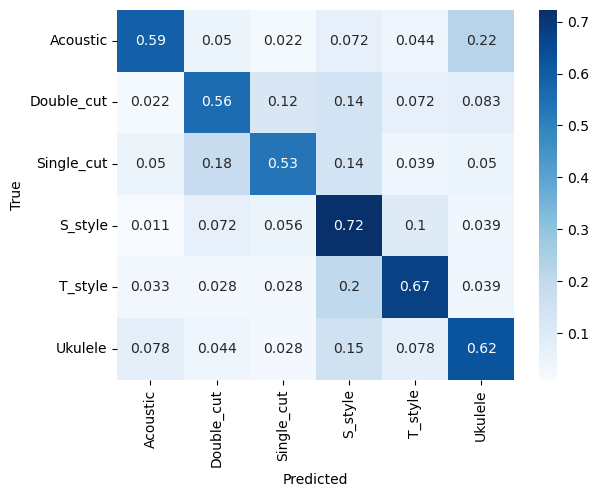

In [12]:
# Evaluate the model
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy:", test_acc)

# confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    xticklabels=CLASES.values(),
    yticklabels=CLASES.values(),
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

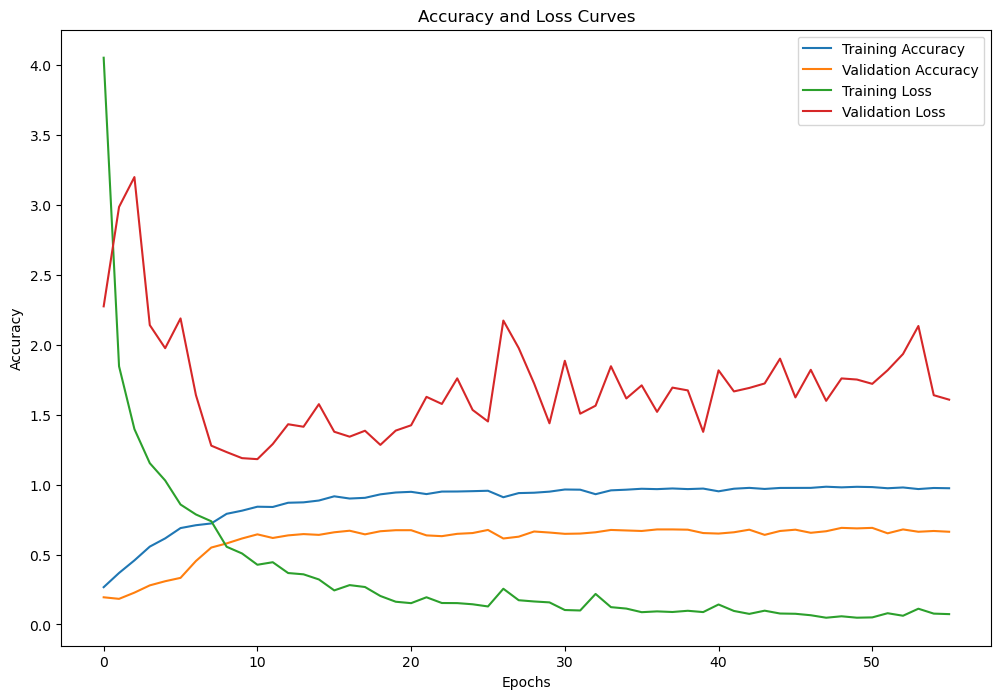

In [13]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 8))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy and Loss Curves")
plt.legend()
plt.show()

In [14]:
# Save the model
model.save("./models/base_model.h5")

In [15]:
# Clear the session and delete the model to free memory
tf.keras.backend.clear_session()
del model
del X
del y
del history

### Hyperparameter tunning

Utilize hyperopt to find the best hyperparameters for the model.


In [17]:
# hyperopt and mlflow imports
import mlflow
import mlflow.tensorflow
import mlflow.keras
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from hyperopt import space_eval
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

mlflow.set_experiment("Guitar Classification")

# define the search space
space = {
    "conv1_filters": hp.choice("conv1_filters", [32, 64, 128]),
    "conv2_filters": hp.choice(
        "conv2_filters",
        [
            32,
            64,
            128,
        ],
    ),
    "conv3_filters": hp.choice("conv3_filters", [64, 128, 256]),
    "conv4_filters": hp.choice("conv4_filters", [64, 128, 256]),
    "dropout": hp.uniform("dropout", 0.2, 0.9),
    "dense": hp.choice("dense", [256, 512, 1024]),
    "batch_size": hp.choice("batch_size", [64, 128, 256]),
    "epochs": hp.choice("epochs", [50, 100, 150]),
    "learning_rate": hp.choice("learning_rate", [0.0001, 0.001, 0.01, 0.1]),
}

# define the objective function to optimize f1_score, accuracy, precision, recall


def objective(space):
    with mlflow.start_run():
        model = Sequential(
            [
                ConvBlock(
                    filters=space["conv1_filters"],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    pool_size=(2, 2),
                    pool_strides=(2, 2),
                    pool_padding="valid",
                    activation="relu",
                ),
                ConvBlock(
                    filters=space["conv2_filters"],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    pool_size=(2, 2),
                    pool_strides=(2, 2),
                    pool_padding="valid",
                    activation="relu",
                ),
                ConvBlock(
                    filters=space["conv3_filters"],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    pool_size=(2, 2),
                    pool_strides=(2, 2),
                    pool_padding="valid",
                    activation="relu",
                ),
                ConvBlock(
                    filters=space["conv4_filters"],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    pool_size=(2, 2),
                    pool_strides=(2, 2),
                    pool_padding="valid",
                    activation="relu",
                ),
                Dropout(space["dropout"]),
                Flatten(),
                Dense(space["dense"], activation="relu"),
                Dense(6, activation="sigmoid"),
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=space["learning_rate"]),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        history = model.fit(
            X_train,
            y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[early_stopping],
        )
        loss, accuracy = model.evaluate(X_test, y_test)
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        acc_scr = accuracy_score(y_test, y_pred)
        mlflow.keras.log_model(model, "model")
        mlflow.log_metric("epochs", space["epochs"])
        mlflow.log_metric("batch_size", space["batch_size"])
        mlflow.log_metric("learning_rate", space["learning_rate"])
        mlflow.log_metric("conv1_filters", space["conv1_filters"])
        mlflow.log_metric("conv2_filters", space["conv2_filters"])
        mlflow.log_metric("conv3_filters", space["conv3_filters"])
        mlflow.log_metric("conv4_filters", space["conv4_filters"])
        mlflow.log_metric("dense", space["dense"])
        mlflow.log_metric("dropout", space["dropout"])
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("accuracy_score", acc_scr)
        # mlflow.log_artifact(
        # './models/hyperopt/model_{}.h5'.format(acc_scr), 'model')
        return {"loss": loss, "status": STATUS_OK, "model": model}


# define the trials object
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=150, trials=trials)

# get the best hyperparameters
best_params = space_eval(space, best)

# create the best model
hyper_params_dict = {
    "conv1_filters": [32, 64, 128, 256],
    "conv2_filters": [32, 64, 128, 256],
    "conv3_filters": [32, 64, 128, 256],
    "conv4_filters": [32, 64, 128, 256],
    "dropout": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "dense": [256, 512, 1024],
    "batch_size": [32, 64, 128],
    "epochs": [50, 100, 150],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
}


# create the best model
best_model = Sequential(
    [
        ConvBlock(
            filters=best_params["conv1_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
        ),
        ConvBlock(
            filters=best_params["conv2_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
        ),
        ConvBlock(
            filters=best_params["conv3_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
        ),
        ConvBlock(
            filters=best_params["conv4_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
        ),
        Dropout(best_params["dropout"]),
        Flatten(),
        Dense(best_params["dense"], activation="relu"),
        Dense(6, activation="sigmoid"),
    ]
)

# compile the best model
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# train the best model
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping],
)

# evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# seaborn confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
labels = CLASES.keys()
sns.heatmap(
    cm, annot=True, square=True, cmap="Blues", xticklabels=labels, yticklabels=labels
)

# save the best model with timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
best_model.save(f"./models/{timestamp}_best_model.h5")

Restoring model weights from the end of the best epoch: 12.

Epoch 57: early stopping                               

34/34 [==============================] - 0s 9ms/step - loss: 1.2424 - accuracy: 0.6157

34/34 [==============================] - 0s 5ms/step  

  0%|          | 0/150 [01:50<?, ?trial/s, best loss=?]

2023/04/25 10:41:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxh2vn5co\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxh2vn5co\model\data\model\assets



  1%|          | 1/150 [02:02<5:03:21, 122.15s/trial, best loss: 1.242449164390564]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Restoring model weights from the end of the best epoch: 9.                         

Epoch 54: early stopping                                                           

34/34 [==============================] - 0s 10ms/step - loss: 1.4837 - accuracy: 0.5991

34/34 [==============================] - 0s 6ms/step                              

  1%|          | 1/150 [04:17<5:03:21, 122.15s/trial, best loss: 1.242449164390564]

2023/04/25 10:43:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpv4oh3m9l\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpv4oh3m9l\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                        

Epoch 56: early stopping                                                           

34/34 [==============================] - 0s 5ms/step - loss: 1.2426 - accuracy: 0.5778

34/34 [==============================] - 0s 3ms/step                              

  1%|▏         | 2/150 [05:22<5:33:46, 135.31s/trial, best loss: 1.242449164390564]

2023/04/25 10:44:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3ec8fwbo\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3ec8fwbo\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                        

Epoch 56: early stopping                                                           

34/34 [==============================] - 0s 9ms/step - loss: 1.1640 - accuracy: 0.6009

34/34 [==============================] - 0s 5ms/step                              

  2%|▏         | 3/150 [07:17<4:12:54, 103.23s/trial, best loss: 1.242449164390564]

2023/04/25 10:46:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpux7tzgew\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpux7tzgew\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                         

Epoch 57: early stopping                                                            

34/34 [==============================] - 0s 4ms/step - loss: 1.2230 - accuracy: 0.6083

34/34 [==============================] - 0s 3ms/step                               

  3%|▎         | 4/150 [08:18<4:21:47, 107.59s/trial, best loss: 1.1639935970306396]

2023/04/25 10:47:48 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl9m736a3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl9m736a3\model\data\model\assets



Restoring model weights from the end of the best epoch: 18.                         

Epoch 63: early stopping                                                           

34/34 [==============================] - 0s 8ms/step - loss: 1.7925 - accuracy: 0.1667

34/34 [==============================] - 0s 6ms/step                              

  3%|▎         | 5/150 [11:01<3:39:26, 90.80s/trial, best loss: 1.1639935970306396]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 10:50:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxtzf2jyj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxtzf2jyj\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                         

Epoch 58: early stopping                                                            

34/34 [==============================] - 0s 7ms/step - loss: 1.1478 - accuracy: 0.6111

34/34 [==============================] - 0s 6ms/step                               

  4%|▍         | 6/150 [13:11<4:37:11, 115.49s/trial, best loss: 1.1639935970306396]

2023/04/25 10:52:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75ih3o_y\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75ih3o_y\model\data\model\assets



34/34 [==============================] - 0s 4ms/step - loss: 1.7952 - accuracy: 0.1667

34/34 [==============================] - 0s 3ms/step                               

  5%|▍         | 7/150 [14:40<4:46:08, 120.06s/trial, best loss: 1.1477513313293457]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 10:54:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpjh1ru_ea\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpjh1ru_ea\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                         

Epoch 57: early stopping                                                            

34/34 [==============================] - 0s 6ms/step - loss: 1.2517 - accuracy: 0.6287

34/34 [==============================] - 0s 4ms/step                               

  5%|▌         | 8/150 [16:12<4:21:29, 110.49s/trial, best loss: 1.1477513313293457]

2023/04/25 10:55:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyyiwbrow\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyyiwbrow\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                         

Epoch 56: early stopping                                                            

34/34 [==============================] - 0s 8ms/step - loss: 1.3009 - accuracy: 0.6037

34/34 [==============================] - 0s 6ms/step                               

  6%|▌         | 9/150 [18:20<4:06:17, 104.80s/trial, best loss: 1.1477513313293457]

2023/04/25 10:57:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpugwq74_2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpugwq74_2\model\data\model\assets



Restoring model weights from the end of the best epoch: 46.                          

Epoch 91: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.6704

34/34 [==============================] - 0s 4ms/step                                

  7%|▋         | 10/150 [20:42<4:21:04, 111.89s/trial, best loss: 1.1477513313293457]

2023/04/25 11:00:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpc4fa0nxx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpc4fa0nxx\model\data\model\assets



Restoring model weights from the end of the best epoch: 8.                           

Epoch 53: early stopping                                                             

34/34 [==============================] - 0s 7ms/step - loss: 1.5809 - accuracy: 0.4093

34/34 [==============================] - 0s 6ms/step                                

  7%|▋         | 11/150 [23:03<4:40:12, 120.95s/trial, best loss: 0.9890724420547485]

2023/04/25 11:02:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpofgee9ub\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpofgee9ub\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                          

Epoch 56: early stopping                                                             

34/34 [==============================] - 0s 6ms/step - loss: 1.2392 - accuracy: 0.6037

34/34 [==============================] - 0s 5ms/step                                

  8%|▊         | 12/150 [24:47<4:52:02, 126.98s/trial, best loss: 0.9890724420547485]

2023/04/25 11:04:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpa5ns8qh5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpa5ns8qh5\model\data\model\assets



Restoring model weights from the end of the best epoch: 2.                           

Epoch 47: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 1.7930 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                

  9%|▊         | 13/150 [25:58<4:34:24, 120.18s/trial, best loss: 0.9890724420547485]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 11:05:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgxny2h33\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgxny2h33\model\data\model\assets



Restoring model weights from the end of the best epoch: 34.                          

Epoch 79: early stopping                                                             

34/34 [==============================] - 0s 6ms/step - loss: 1.7928 - accuracy: 0.1667

34/34 [==============================] - 0s 5ms/step                                

  9%|▉         | 14/150 [28:35<3:58:59, 105.44s/trial, best loss: 0.9890724420547485]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 11:08:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpilor8sak\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpilor8sak\model\data\model\assets



34/34 [==============================] - 0s 7ms/step - loss: 1.4830 - accuracy: 0.5713

34/34 [==============================] - 0s 6ms/step                                

 10%|█         | 15/150 [32:08<4:32:17, 121.02s/trial, best loss: 0.9890724420547485]

2023/04/25 11:11:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmplrz90hfw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmplrz90hfw\model\data\model\assets



Restoring model weights from the end of the best epoch: 18.                          

Epoch 63: early stopping                                                             

34/34 [==============================] - 0s 4ms/step - loss: 1.7919 - accuracy: 0.1667

34/34 [==============================] - 0s 3ms/step                                

 11%|█         | 16/150 [33:16<5:32:00, 148.66s/trial, best loss: 0.9890724420547485]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 11:12:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmps0qn1zlk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmps0qn1zlk\model\data\model\assets



Restoring model weights from the end of the best epoch: 14.                          

Epoch 59: early stopping                                                             

34/34 [==============================] - 0s 7ms/step - loss: 1.7070 - accuracy: 0.6259

34/34 [==============================] - 0s 6ms/step                                

 11%|█▏        | 17/150 [35:33<4:36:13, 124.61s/trial, best loss: 0.9890724420547485]

2023/04/25 11:15:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpook4u1ox\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpook4u1ox\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                          

Epoch 55: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 1.6395 - accuracy: 0.6130

34/34 [==============================] - 0s 4ms/step                                

 12%|█▏        | 18/150 [37:02<4:42:38, 128.47s/trial, best loss: 0.9890724420547485]

2023/04/25 11:16:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_813_o15\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_813_o15\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                          

Epoch 56: early stopping                                                             

34/34 [==============================] - 0s 6ms/step - loss: 1.1913 - accuracy: 0.5935

34/34 [==============================] - 0s 5ms/step                                

 13%|█▎        | 19/150 [38:50<4:13:47, 116.24s/trial, best loss: 0.9890724420547485]

2023/04/25 11:18:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpswksoadc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpswksoadc\model\data\model\assets



34/34 [==============================] - 0s 6ms/step - loss: 0.9104 - accuracy: 0.7352

34/34 [==============================] - 0s 4ms/step                                

 13%|█▎        | 20/150 [41:33<4:06:18, 113.68s/trial, best loss: 0.9890724420547485]

2023/04/25 11:21:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpp5er4885\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpp5er4885\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.7677 - accuracy: 0.7269

34/34 [==============================] - 0s 4ms/step                                

 14%|█▍        | 21/150 [44:12<4:35:42, 128.24s/trial, best loss: 0.9103933572769165]

2023/04/25 11:23:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpd3k_74sg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpd3k_74sg\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8169 - accuracy: 0.7454

34/34 [==============================] - 0s 4ms/step                                

 15%|█▍        | 22/150 [46:53<4:53:36, 137.63s/trial, best loss: 0.7677318453788757]

2023/04/25 11:26:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgoh6xrut\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgoh6xrut\model\data\model\assets



Restoring model weights from the end of the best epoch: 21.                          

Epoch 66: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 0.8911 - accuracy: 0.6731

34/34 [==============================] - 0s 4ms/step                                

 15%|█▌        | 23/150 [48:44<5:05:55, 144.53s/trial, best loss: 0.7677318453788757]

2023/04/25 11:28:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2k6y09zu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2k6y09zu\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 1.1249 - accuracy: 0.7037

34/34 [==============================] - 0s 4ms/step                                

 16%|█▌        | 24/150 [51:25<4:42:41, 134.61s/trial, best loss: 0.7677318453788757]

2023/04/25 11:30:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpszcom111\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpszcom111\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                           

Epoch 54: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 1.2424 - accuracy: 0.5926

34/34 [==============================] - 0s 4ms/step                                

 17%|█▋        | 25/150 [53:00<4:56:40, 142.40s/trial, best loss: 0.7677318453788757]

2023/04/25 11:32:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp76gfixlw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp76gfixlw\model\data\model\assets



Restoring model weights from the end of the best epoch: 49.                          

Epoch 94: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 1.0900 - accuracy: 0.5694

34/34 [==============================] - 0s 4ms/step                                

 17%|█▋        | 26/150 [55:31<4:24:49, 128.14s/trial, best loss: 0.7677318453788757]

2023/04/25 11:35:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1g755gub\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1g755gub\model\data\model\assets



Restoring model weights from the end of the best epoch: 19.                          

Epoch 64: early stopping                                                             

34/34 [==============================] - 0s 5ms/step - loss: 0.9547 - accuracy: 0.6704

34/34 [==============================] - 0s 4ms/step                                

 18%|█▊        | 27/150 [57:20<4:36:52, 135.06s/trial, best loss: 0.7677318453788757]

2023/04/25 11:36:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpwpnez7nh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpwpnez7nh\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8835 - accuracy: 0.7324

34/34 [==============================] - 0s 4ms/step                                  

 19%|█▊        | 28/150 [1:00:01<4:18:36, 127.19s/trial, best loss: 0.7677318453788757]

2023/04/25 11:39:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5_s8o7i3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5_s8o7i3\model\data\model\assets



Restoring model weights from the end of the best epoch: 16.                            

Epoch 61: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.0051 - accuracy: 0.6472

34/34 [==============================] - 0s 4ms/step                                  

 19%|█▉        | 29/150 [1:01:45<4:37:01, 137.37s/trial, best loss: 0.7677318453788757]

2023/04/25 11:41:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpd7i5kgno\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpd7i5kgno\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8663 - accuracy: 0.7296

34/34 [==============================] - 0s 4ms/step                                  

 20%|██        | 30/150 [1:04:27<4:14:57, 127.48s/trial, best loss: 0.7677318453788757]

2023/04/25 11:43:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp154far2o\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp154far2o\model\data\model\assets



Restoring model weights from the end of the best epoch: 33.                            

Epoch 78: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.5735 - accuracy: 0.5639

34/34 [==============================] - 0s 4ms/step                                  

 21%|██        | 31/150 [1:06:37<4:33:09, 137.73s/trial, best loss: 0.7677318453788757]

2023/04/25 11:46:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpfnvvxy_p\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpfnvvxy_p\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                            

Epoch 55: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.1197 - accuracy: 0.6296

34/34 [==============================] - 0s 4ms/step                                  

 21%|██▏       | 32/150 [1:08:11<4:26:04, 135.29s/trial, best loss: 0.7677318453788757]

2023/04/25 11:47:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkksi2un5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkksi2un5\model\data\model\assets



Restoring model weights from the end of the best epoch: 41.                            

Epoch 86: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.8591 - accuracy: 0.7065

34/34 [==============================] - 0s 4ms/step                                  

 22%|██▏       | 33/150 [1:10:30<3:59:32, 122.84s/trial, best loss: 0.7677318453788757]

2023/04/25 11:50:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphicxgysu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphicxgysu\model\data\model\assets



Restoring model weights from the end of the best epoch: 15.                            

Epoch 60: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.0570 - accuracy: 0.6593

34/34 [==============================] - 0s 4ms/step                                  

 23%|██▎       | 34/150 [1:12:12<4:07:26, 127.99s/trial, best loss: 0.7677318453788757]

2023/04/25 11:51:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpj8eh0q3s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpj8eh0q3s\model\data\model\assets



Restoring model weights from the end of the best epoch: 7.                             

Epoch 52: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.5728 - accuracy: 0.3769

34/34 [==============================] - 0s 4ms/step                                  

 23%|██▎       | 35/150 [1:13:25<3:49:44, 119.87s/trial, best loss: 0.7677318453788757]

2023/04/25 11:52:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpagfsr8yy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpagfsr8yy\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8651 - accuracy: 0.7204

34/34 [==============================] - 0s 4ms/step                                  

 24%|██▍       | 36/150 [1:15:48<3:21:50, 106.23s/trial, best loss: 0.7677318453788757]

2023/04/25 11:55:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_8tq5hz2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_8tq5hz2\model\data\model\assets



Restoring model weights from the end of the best epoch: 16.                            

Epoch 61: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7919 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 25%|██▍       | 37/150 [1:17:30<3:40:11, 116.92s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 11:57:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5j90qc_m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5j90qc_m\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                            

Epoch 56: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.0396 - accuracy: 0.6398

34/34 [==============================] - 0s 3ms/step                                  

 25%|██▌       | 38/150 [1:18:29<3:30:05, 112.55s/trial, best loss: 0.7677318453788757]

2023/04/25 11:57:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkmpi2llu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkmpi2llu\model\data\model\assets



Restoring model weights from the end of the best epoch: 19.                            

Epoch 64: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.5645 - accuracy: 0.6620

34/34 [==============================] - 0s 4ms/step                                 

 26%|██▌       | 39/150 [1:20:16<2:58:19, 96.39s/trial, best loss: 0.7677318453788757]

2023/04/25 11:59:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphw1b8iea\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphw1b8iea\model\data\model\assets



34/34 [==============================] - 0s 8ms/step - loss: 0.8835 - accuracy: 0.7157

34/34 [==============================] - 0s 7ms/step                                 

 27%|██▋       | 40/150 [1:24:44<3:02:48, 99.71s/trial, best loss: 0.7677318453788757]

2023/04/25 12:04:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp33_0cvcc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp33_0cvcc\model\data\model\assets



Restoring model weights from the end of the best epoch: 27.                            

Epoch 72: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7931 - accuracy: 0.1704

34/34 [==============================] - 0s 4ms/step                                  

 27%|██▋       | 41/150 [1:26:35<4:32:55, 150.23s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:06:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpevk4uihz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpevk4uihz\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                            

Epoch 58: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.7928 - accuracy: 0.1667

34/34 [==============================] - 0s 3ms/step                                  

 28%|██▊       | 42/150 [1:27:45<4:09:17, 138.50s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:07:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpn58ywiek\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpn58ywiek\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                             

Epoch 54: early stopping                                                               

34/34 [==============================] - 0s 6ms/step - loss: 1.1646 - accuracy: 0.5991

34/34 [==============================] - 0s 5ms/step                                  

 29%|██▊       | 43/150 [1:29:35<3:30:12, 117.88s/trial, best loss: 0.7677318453788757]

2023/04/25 12:09:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpa7xj4a75\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpa7xj4a75\model\data\model\assets



Restoring model weights from the end of the best epoch: 29.                            

Epoch 74: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 1.1115 - accuracy: 0.6593

34/34 [==============================] - 0s 6ms/step                                  

 29%|██▉       | 44/150 [1:32:22<3:24:23, 115.69s/trial, best loss: 0.7677318453788757]

2023/04/25 12:11:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_ig_iscq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_ig_iscq\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                             

Epoch 54: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.5199 - accuracy: 0.5889

34/34 [==============================] - 0s 4ms/step                                  

 30%|███       | 45/150 [1:33:39<3:49:21, 131.07s/trial, best loss: 0.7677318453788757]

2023/04/25 12:13:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpvp_7wvwk\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpvp_7wvwk\model\data\model\assets



Restoring model weights from the end of the best epoch: 6.                             

Epoch 51: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 2.5957 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 31%|███       | 46/150 [1:34:50<3:18:44, 114.66s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:14:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpz3tpwx8u\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpz3tpwx8u\model\data\model\assets



34/34 [==============================] - 0s 7ms/step - loss: 1.0913 - accuracy: 0.5981

34/34 [==============================] - 0s 7ms/step                                  

 31%|███▏      | 47/150 [1:39:00<2:54:04, 101.40s/trial, best loss: 0.7677318453788757]

2023/04/25 12:18:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdfm7qtqp\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdfm7qtqp\model\data\model\assets



Restoring model weights from the end of the best epoch: 20.                            

Epoch 65: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.1523 - accuracy: 0.6241

34/34 [==============================] - 0s 4ms/step                                  

 32%|███▏      | 48/150 [1:40:44<4:09:58, 147.04s/trial, best loss: 0.7677318453788757]

2023/04/25 12:20:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpvkv2cjz0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpvkv2cjz0\model\data\model\assets



Restoring model weights from the end of the best epoch: 15.                            

Epoch 60: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 1.6762 - accuracy: 0.6556

34/34 [==============================] - 0s 6ms/step                                  

 33%|███▎      | 49/150 [1:42:59<3:44:30, 133.38s/trial, best loss: 0.7677318453788757]

2023/04/25 12:22:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpynulef7i\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpynulef7i\model\data\model\assets



Restoring model weights from the end of the best epoch: 6.                             

Epoch 51: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7926 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 33%|███▎      | 50/150 [1:44:27<3:42:54, 133.75s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:23:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpzhhbdbw9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpzhhbdbw9\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                            

Epoch 57: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.0822 - accuracy: 0.6481

34/34 [==============================] - 0s 4ms/step                                  

 34%|███▍      | 51/150 [1:45:48<3:18:16, 120.17s/trial, best loss: 0.7677318453788757]

2023/04/25 12:25:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3vfn6nzz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3vfn6nzz\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                            

Epoch 56: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.2082 - accuracy: 0.6130

34/34 [==============================] - 0s 4ms/step                                  

 35%|███▍      | 52/150 [1:47:20<2:57:03, 108.41s/trial, best loss: 0.7677318453788757]

2023/04/25 12:26:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdk3p181h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdk3p181h\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                            

Epoch 58: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.3571 - accuracy: 0.6648

34/34 [==============================] - 0s 4ms/step                                  

 35%|███▌      | 53/150 [1:49:01<2:47:16, 103.47s/trial, best loss: 0.7677318453788757]

2023/04/25 12:28:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdew_2nm6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdew_2nm6\model\data\model\assets



Restoring model weights from the end of the best epoch: 41.                            

Epoch 86: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 1.1858 - accuracy: 0.5676

34/34 [==============================] - 0s 5ms/step                                  

 36%|███▌      | 54/150 [1:51:48<2:43:53, 102.43s/trial, best loss: 0.7677318453788757]

2023/04/25 12:31:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4dhnersd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4dhnersd\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                             

Epoch 54: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.1839 - accuracy: 0.6157

34/34 [==============================] - 0s 4ms/step                                  

 37%|███▋      | 55/150 [1:53:20<3:13:51, 122.44s/trial, best loss: 0.7677318453788757]

2023/04/25 12:32:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp354l6w1l\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp354l6w1l\model\data\model\assets



34/34 [==============================] - 1s 25ms/step - loss: 1.7971 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 37%|███▋      | 56/150 [1:56:12<2:58:15, 113.78s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:35:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprh06u91r\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprh06u91r\model\data\model\assets



Restoring model weights from the end of the best epoch: 38.                            

Epoch 83: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.0145 - accuracy: 0.6824

34/34 [==============================] - 0s 4ms/step                                  

 38%|███▊      | 57/150 [1:58:15<3:22:09, 130.43s/trial, best loss: 0.7677318453788757]

2023/04/25 12:37:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp01binf0m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp01binf0m\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.9168 - accuracy: 0.6722

34/34 [==============================] - 0s 4ms/step                                  

 39%|███▊      | 58/150 [2:00:57<3:16:35, 128.21s/trial, best loss: 0.7677318453788757]

2023/04/25 12:40:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpt6d7iwl8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpt6d7iwl8\model\data\model\assets



Restoring model weights from the end of the best epoch: 31.                            

Epoch 76: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 0.9172 - accuracy: 0.6704

34/34 [==============================] - 0s 6ms/step                                  

 39%|███▉      | 59/150 [2:04:06<3:30:00, 138.47s/trial, best loss: 0.7677318453788757]

2023/04/25 12:43:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcqb1qu_m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcqb1qu_m\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                            

Epoch 55: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.1101 - accuracy: 0.6185

34/34 [==============================] - 0s 4ms/step                                  

 40%|████      | 60/150 [2:05:43<3:50:25, 153.62s/trial, best loss: 0.7677318453788757]

2023/04/25 12:45:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4iv2bje3\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4iv2bje3\model\data\model\assets



Restoring model weights from the end of the best epoch: 44.                            

Epoch 89: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.5785 - accuracy: 0.3815

34/34 [==============================] - 0s 3ms/step                                  

 41%|████      | 61/150 [2:07:28<3:22:34, 136.56s/trial, best loss: 0.7677318453788757]

2023/04/25 12:46:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqv7sbzfi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqv7sbzfi\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                             

Epoch 54: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.2562 - accuracy: 0.5972

34/34 [==============================] - 0s 4ms/step                                  

 41%|████▏     | 62/150 [2:08:53<3:06:11, 126.95s/trial, best loss: 0.7677318453788757]

2023/04/25 12:48:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2mq4s_h_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2mq4s_h_\model\data\model\assets



Restoring model weights from the end of the best epoch: 26.                            

Epoch 71: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7923 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 42%|████▏     | 63/150 [2:10:51<2:45:43, 114.29s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 12:50:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp59g6jyc0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp59g6jyc0\model\data\model\assets



34/34 [==============================] - 0s 7ms/step - loss: 0.9259 - accuracy: 0.7157

34/34 [==============================] - 0s 6ms/step                                  

 43%|████▎     | 64/150 [2:14:22<2:45:37, 115.55s/trial, best loss: 0.7677318453788757]

2023/04/25 12:53:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnh9foooy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnh9foooy\model\data\model\assets



34/34 [==============================] - 0s 6ms/step - loss: 1.0275 - accuracy: 0.7222

34/34 [==============================] - 0s 4ms/step                                  

 43%|████▎     | 65/150 [2:17:06<3:24:38, 144.45s/trial, best loss: 0.7677318453788757]

2023/04/25 12:56:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp9nn8d6cj\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp9nn8d6cj\model\data\model\assets



Restoring model weights from the end of the best epoch: 30.                            

Epoch 75: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.9332 - accuracy: 0.6991

34/34 [==============================] - 0s 4ms/step                                  

 44%|████▍     | 66/150 [2:19:12<3:29:55, 149.95s/trial, best loss: 0.7677318453788757]

2023/04/25 12:58:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprv4g_fo2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprv4g_fo2\model\data\model\assets



Restoring model weights from the end of the best epoch: 26.                            

Epoch 71: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.9147 - accuracy: 0.6759

34/34 [==============================] - 0s 4ms/step                                  

 45%|████▍     | 67/150 [2:21:11<3:17:26, 142.73s/trial, best loss: 0.7677318453788757]

2023/04/25 13:00:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpg7tsbu4j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpg7tsbu4j\model\data\model\assets



Restoring model weights from the end of the best epoch: 48.                            

Epoch 93: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.7919 - accuracy: 0.7185

34/34 [==============================] - 0s 4ms/step                                  

 45%|████▌     | 68/150 [2:23:43<3:05:30, 135.74s/trial, best loss: 0.7677318453788757]

2023/04/25 13:03:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmptblf443p\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmptblf443p\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.7703 - accuracy: 0.7472

34/34 [==============================] - 0s 4ms/step                                  

 46%|████▌     | 69/150 [2:26:28<3:09:54, 140.68s/trial, best loss: 0.7677318453788757]

2023/04/25 13:05:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpn0h53swx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpn0h53swx\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8248 - accuracy: 0.7185

34/34 [==============================] - 0s 4ms/step                                  

 47%|████▋     | 70/150 [2:29:10<3:17:12, 147.90s/trial, best loss: 0.7677318453788757]

2023/04/25 13:08:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphnwrj7ld\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphnwrj7ld\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 1.1415 - accuracy: 0.7259

34/34 [==============================] - 0s 4ms/step                                  

 47%|████▋     | 71/150 [2:31:51<3:20:05, 151.97s/trial, best loss: 0.7677318453788757]

2023/04/25 13:11:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp11_h_bza\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp11_h_bza\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                            

Epoch 56: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.0408 - accuracy: 0.6509

34/34 [==============================] - 0s 4ms/step                                  

 48%|████▊     | 72/150 [2:33:27<3:21:01, 154.63s/trial, best loss: 0.7677318453788757]

2023/04/25 13:12:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl60hw6tm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl60hw6tm\model\data\model\assets



Restoring model weights from the end of the best epoch: 14.                            

Epoch 59: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.9992 - accuracy: 0.6481

34/34 [==============================] - 0s 4ms/step                                  

 49%|████▊     | 73/150 [2:35:09<2:56:07, 137.25s/trial, best loss: 0.7677318453788757]

2023/04/25 13:14:39 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyxqio7kx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyxqio7kx\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.9202 - accuracy: 0.6907

34/34 [==============================] - 0s 4ms/step                                  

 49%|████▉     | 74/150 [2:37:54<2:40:41, 126.86s/trial, best loss: 0.7677318453788757]

2023/04/25 13:17:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75i65jz0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75i65jz0\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                            

Epoch 58: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.0453 - accuracy: 0.6176

34/34 [==============================] - 0s 4ms/step                                  

 50%|█████     | 75/150 [2:39:34<2:52:45, 138.20s/trial, best loss: 0.7677318453788757]

2023/04/25 13:19:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp12bjbjr7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp12bjbjr7\model\data\model\assets



Restoring model weights from the end of the best epoch: 6.                             

Epoch 51: early stopping                                                               

34/34 [==============================] - 0s 6ms/step - loss: 1.7082 - accuracy: 0.2380

34/34 [==============================] - 0s 5ms/step                                  

 51%|█████     | 76/150 [2:41:19<2:36:02, 126.52s/trial, best loss: 0.7677318453788757]

2023/04/25 13:20:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1injzr7i\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1injzr7i\model\data\model\assets



Restoring model weights from the end of the best epoch: 17.                            

Epoch 62: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 0.9490 - accuracy: 0.6694

34/34 [==============================] - 0s 3ms/step                                  

 51%|█████▏    | 77/150 [2:42:32<2:25:58, 119.98s/trial, best loss: 0.7677318453788757]

2023/04/25 13:22:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4rlo1kzf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4rlo1kzf\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                            

Epoch 55: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.4605 - accuracy: 0.6259

34/34 [==============================] - 0s 4ms/step                                  

 52%|█████▏    | 78/150 [2:44:03<2:07:05, 105.91s/trial, best loss: 0.7677318453788757]

2023/04/25 13:23:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp0bg2vpxd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp0bg2vpxd\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8407 - accuracy: 0.7194

34/34 [==============================] - 0s 4ms/step                                  

 53%|█████▎    | 79/150 [2:46:45<2:00:13, 101.59s/trial, best loss: 0.7677318453788757]

2023/04/25 13:26:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk1t4lkoi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk1t4lkoi\model\data\model\assets



Restoring model weights from the end of the best epoch: 8.                             

Epoch 53: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7930 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                  

 53%|█████▎    | 80/150 [2:48:19<2:19:53, 119.90s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 13:27:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpw2nfyjon\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpw2nfyjon\model\data\model\assets



34/34 [==============================] - 0s 7ms/step - loss: 1.1211 - accuracy: 0.6907

34/34 [==============================] - 0s 6ms/step                                  

 54%|█████▍    | 81/150 [2:52:24<2:08:45, 111.96s/trial, best loss: 0.7677318453788757]

2023/04/25 13:31:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpreeiulre\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpreeiulre\model\data\model\assets



Restoring model weights from the end of the best epoch: 18.                            

Epoch 63: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.5634 - accuracy: 0.4509

34/34 [==============================] - 0s 4ms/step                                  

 55%|█████▍    | 82/150 [2:53:58<2:52:12, 151.95s/trial, best loss: 0.7677318453788757]

2023/04/25 13:33:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpf741xtcz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpf741xtcz\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                            

Epoch 55: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.3939 - accuracy: 0.6444

34/34 [==============================] - 0s 4ms/step                                  

 55%|█████▌    | 83/150 [2:55:17<2:29:56, 134.28s/trial, best loss: 0.7677318453788757]

2023/04/25 13:34:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcq6rac3_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcq6rac3_\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                            

Epoch 57: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.2019 - accuracy: 0.6491

34/34 [==============================] - 0s 4ms/step                                  

 56%|█████▌    | 84/150 [2:56:47<2:09:39, 117.87s/trial, best loss: 0.7677318453788757]

2023/04/25 13:36:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5kjbm7jq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp5kjbm7jq\model\data\model\assets



Restoring model weights from the end of the best epoch: 2.                             

Epoch 47: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 3.1441 - accuracy: 0.1657

34/34 [==============================] - 0s 4ms/step                                  

 57%|█████▋    | 85/150 [2:58:10<1:58:35, 109.47s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 13:37:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk5j0hm_h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk5j0hm_h\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                            

Epoch 57: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 1.0396 - accuracy: 0.6287

34/34 [==============================] - 0s 6ms/step                                  

 57%|█████▋    | 86/150 [3:00:17<1:48:27, 101.68s/trial, best loss: 0.7677318453788757]

2023/04/25 13:39:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2j483wpr\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2j483wpr\model\data\model\assets



Restoring model weights from the end of the best epoch: 26.                            

Epoch 71: early stopping                                                               

34/34 [==============================] - 0s 6ms/step - loss: 1.0410 - accuracy: 0.6574

34/34 [==============================] - 0s 5ms/step                                  

 58%|█████▊    | 87/150 [3:02:41<1:54:19, 108.89s/trial, best loss: 0.7677318453788757]

2023/04/25 13:42:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprzh6yyew\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprzh6yyew\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                            

Epoch 57: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.2195 - accuracy: 0.6546

34/34 [==============================] - 0s 3ms/step                                  

 59%|█████▊    | 88/150 [3:03:48<2:03:24, 119.42s/trial, best loss: 0.7677318453788757]

2023/04/25 13:43:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4hict4g0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4hict4g0\model\data\model\assets



Restoring model weights from the end of the best epoch: 46.                            

Epoch 91: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.6730 - accuracy: 0.2519

34/34 [==============================] - 0s 4ms/step                                  

 59%|█████▉    | 89/150 [3:06:07<1:45:26, 103.71s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 13:45:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpwa47tw5m\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpwa47tw5m\model\data\model\assets



Restoring model weights from the end of the best epoch: 20.                            

Epoch 65: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.8889 - accuracy: 0.6870

34/34 [==============================] - 0s 4ms/step                                  

 60%|██████    | 90/150 [3:07:57<1:54:25, 114.43s/trial, best loss: 0.7677318453788757]

2023/04/25 13:47:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnvg14nrc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnvg14nrc\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.9442 - accuracy: 0.6898

34/34 [==============================] - 0s 5ms/step                                  

 61%|██████    | 91/150 [3:10:39<1:51:39, 113.55s/trial, best loss: 0.7677318453788757]

2023/04/25 13:50:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcixyj3k8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcixyj3k8\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                            

Epoch 58: early stopping                                                               

34/34 [==============================] - 0s 7ms/step - loss: 1.7923 - accuracy: 0.1667

34/34 [==============================] - 0s 6ms/step                                  

 61%|██████▏   | 92/150 [3:13:04<2:03:46, 128.05s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 13:52:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgdmcj6yb\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgdmcj6yb\model\data\model\assets



Restoring model weights from the end of the best epoch: 37.                            

Epoch 82: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.9076 - accuracy: 0.6787

34/34 [==============================] - 0s 4ms/step                                  

 62%|██████▏   | 93/150 [3:15:03<2:06:14, 132.89s/trial, best loss: 0.7677318453788757]

2023/04/25 13:54:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4t4ig0pd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp4t4ig0pd\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                            

Epoch 55: early stopping                                                               

34/34 [==============================] - 0s 4ms/step - loss: 1.1930 - accuracy: 0.5898

34/34 [==============================] - 0s 4ms/step                                  

 63%|██████▎   | 94/150 [3:16:23<2:00:04, 128.65s/trial, best loss: 0.7677318453788757]

2023/04/25 13:55:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp9n7ddoq6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp9n7ddoq6\model\data\model\assets



Restoring model weights from the end of the best epoch: 34.                            

Epoch 79: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 0.9276 - accuracy: 0.6917

34/34 [==============================] - 0s 4ms/step                                  

 63%|██████▎   | 95/150 [3:18:21<1:44:31, 114.04s/trial, best loss: 0.7677318453788757]

2023/04/25 13:57:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpi08r02x9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpi08r02x9\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                            

Epoch 58: early stopping                                                               

34/34 [==============================] - 0s 5ms/step - loss: 1.7672 - accuracy: 0.2306

34/34 [==============================] - 0s 4ms/step                                  

 64%|██████▍   | 96/150 [3:19:59<1:43:43, 115.25s/trial, best loss: 0.7677318453788757]

2023/04/25 13:59:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxnc__gyq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpxnc__gyq\model\data\model\assets



34/34 [==============================] - 0s 7ms/step - loss: 1.0638 - accuracy: 0.6944

34/34 [==============================] - 0s 6ms/step                                  

 65%|██████▍   | 97/150 [3:23:28<1:37:42, 110.60s/trial, best loss: 0.7677318453788757]

2023/04/25 14:02:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmps0cdn9yp\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmps0cdn9yp\model\data\model\assets



Restoring model weights from the end of the best epoch: 30.                            

Epoch 75: early stopping                                                               

34/34 [==============================] - 0s 6ms/step - loss: 1.7921 - accuracy: 0.1667

34/34 [==============================] - 0s 5ms/step                                  

 65%|██████▌   | 98/150 [3:25:58<2:01:15, 139.91s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 14:05:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgwcr9ijw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpgwcr9ijw\model\data\model\assets



34/34 [==============================] - 0s 4ms/step - loss: 0.9675 - accuracy: 0.6926

34/34 [==============================] - 0s 3ms/step                                  

 66%|██████▌   | 99/150 [3:27:45<2:01:12, 142.59s/trial, best loss: 0.7677318453788757]

2023/04/25 14:07:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqpfwyyow\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqpfwyyow\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                              

Epoch 54: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.3936 - accuracy: 0.6065 

34/34 [==============================] - 0s 4ms/step                                   

 67%|██████▋   | 100/150 [3:29:23<1:49:49, 131.78s/trial, best loss: 0.7677318453788757]

2023/04/25 14:08:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpq3regl8_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpq3regl8_\model\data\model\assets



Restoring model weights from the end of the best epoch: 24.                             

Epoch 69: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.1450 - accuracy: 0.6324 

34/34 [==============================] - 0s 4ms/step                                   

 67%|██████▋   | 101/150 [3:31:07<1:39:32, 121.88s/trial, best loss: 0.7677318453788757]

2023/04/25 14:10:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpjd_l22ew\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpjd_l22ew\model\data\model\assets



Restoring model weights from the end of the best epoch: 28.                             

Epoch 73: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 0.9780 - accuracy: 0.6861 

34/34 [==============================] - 0s 4ms/step                                   

 68%|██████▊   | 102/150 [3:33:10<1:33:07, 116.40s/trial, best loss: 0.7677318453788757]

2023/04/25 14:12:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppgzuuhdm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppgzuuhdm\model\data\model\assets



Restoring model weights from the end of the best epoch: 33.                             

Epoch 78: early stopping                                                                

34/34 [==============================] - 0s 7ms/step - loss: 1.1941 - accuracy: 0.5694 

34/34 [==============================] - 0s 6ms/step                                   

 69%|██████▊   | 103/150 [3:35:57<1:33:05, 118.83s/trial, best loss: 0.7677318453788757]

2023/04/25 14:15:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2oivkucm\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2oivkucm\model\data\model\assets



Restoring model weights from the end of the best epoch: 51.                             

Epoch 96: early stopping                                                                

34/34 [==============================] - 0s 6ms/step - loss: 0.9862 - accuracy: 0.6694 

34/34 [==============================] - 0s 5ms/step                                   

 69%|██████▉   | 104/150 [3:39:07<1:42:06, 133.19s/trial, best loss: 0.7677318453788757]

2023/04/25 14:18:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpc39aov86\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpc39aov86\model\data\model\assets



Restoring model weights from the end of the best epoch: 16.                             

Epoch 61: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 0.9860 - accuracy: 0.6528 

34/34 [==============================] - 0s 4ms/step                                   

 70%|███████   | 105/150 [3:40:39<1:52:25, 149.91s/trial, best loss: 0.7677318453788757]

2023/04/25 14:20:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpaa1x0pgh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpaa1x0pgh\model\data\model\assets



Restoring model weights from the end of the best epoch: 39.                             

Epoch 84: early stopping                                                                

34/34 [==============================] - 0s 4ms/step - loss: 1.7923 - accuracy: 0.1667 

34/34 [==============================] - 0s 4ms/step                                   

 71%|███████   | 106/150 [3:42:31<1:37:02, 132.33s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 14:22:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpaqra0ol2\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpaqra0ol2\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                             

Epoch 55: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.3089 - accuracy: 0.6324 

34/34 [==============================] - 0s 4ms/step                                   

 71%|███████▏  | 107/150 [3:43:57<1:30:42, 126.58s/trial, best loss: 0.7677318453788757]

2023/04/25 14:23:27 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_86a6yzv\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp_86a6yzv\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 1.0146 - accuracy: 0.7000 

34/34 [==============================] - 0s 5ms/step                                   

 72%|███████▏  | 108/150 [3:46:39<1:19:53, 114.12s/trial, best loss: 0.7677318453788757]

2023/04/25 14:26:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyc_pmzog\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpyc_pmzog\model\data\model\assets



Restoring model weights from the end of the best epoch: 17.                             

Epoch 62: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 0.9864 - accuracy: 0.6352 

34/34 [==============================] - 0s 4ms/step                                   

 73%|███████▎  | 109/150 [3:48:14<1:28:09, 129.02s/trial, best loss: 0.7677318453788757]

2023/04/25 14:27:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75je55f6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp75je55f6\model\data\model\assets



34/34 [==============================] - 0s 8ms/step - loss: 1.1383 - accuracy: 0.6028 

34/34 [==============================] - 0s 7ms/step                                   

 73%|███████▎  | 110/150 [3:52:40<1:19:09, 118.74s/trial, best loss: 0.7677318453788757]

2023/04/25 14:32:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpslm3a2l4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpslm3a2l4\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                              

Epoch 54: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.3059 - accuracy: 0.6269 

34/34 [==============================] - 0s 5ms/step                                   

 74%|███████▍  | 111/150 [3:54:17<1:45:38, 162.52s/trial, best loss: 0.7677318453788757]

2023/04/25 14:33:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp6029n161\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp6029n161\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                             

Epoch 57: early stopping                                                                

34/34 [==============================] - 0s 4ms/step - loss: 1.3847 - accuracy: 0.6602 

34/34 [==============================] - 0s 3ms/step                                   

 75%|███████▍  | 112/150 [3:55:27<1:30:30, 142.90s/trial, best loss: 0.7677318453788757]

2023/04/25 14:34:57 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpx8787w5d\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpx8787w5d\model\data\model\assets



Restoring model weights from the end of the best epoch: 14.                             

Epoch 59: early stopping                                                                

34/34 [==============================] - 0s 6ms/step - loss: 1.7926 - accuracy: 0.1667 

34/34 [==============================] - 0s 6ms/step                                   

 75%|███████▌  | 113/150 [3:57:05<1:14:38, 121.03s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 14:36:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpef7lsbmi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpef7lsbmi\model\data\model\assets



34/34 [==============================] - 0s 6ms/step - loss: 0.8858 - accuracy: 0.7269 

34/34 [==============================] - 0s 4ms/step                                   

 76%|███████▌  | 114/150 [3:59:52<1:08:44, 114.58s/trial, best loss: 0.7677318453788757]

2023/04/25 14:39:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpsw877sma\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpsw877sma\model\data\model\assets



Restoring model weights from the end of the best epoch: 14.                             

Epoch 59: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.1198 - accuracy: 0.6093 

34/34 [==============================] - 0s 4ms/step                                   

 77%|███████▋  | 115/150 [4:01:39<1:16:15, 130.72s/trial, best loss: 0.7677318453788757]

2023/04/25 14:41:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1peoxlef\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp1peoxlef\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                             

Epoch 57: early stopping                                                                

34/34 [==============================] - 0s 7ms/step - loss: 1.1533 - accuracy: 0.6287 

34/34 [==============================] - 0s 6ms/step                                   

 77%|███████▋  | 116/150 [4:04:11<1:10:12, 123.91s/trial, best loss: 0.7677318453788757]

2023/04/25 14:43:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp0nzkc0er\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp0nzkc0er\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 1.0167 - accuracy: 0.6185 

34/34 [==============================] - 0s 4ms/step                                   

 78%|███████▊  | 117/150 [4:07:01<1:12:18, 131.48s/trial, best loss: 0.7677318453788757]

2023/04/25 14:46:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3yozffgl\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3yozffgl\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                              

Epoch 54: early stopping                                                                

34/34 [==============================] - 0s 4ms/step - loss: 1.2899 - accuracy: 0.5935 

34/34 [==============================] - 0s 4ms/step                                   

 79%|███████▊  | 118/150 [4:08:07<1:16:07, 142.74s/trial, best loss: 0.7677318453788757]

2023/04/25 14:47:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpryhxzb8k\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpryhxzb8k\model\data\model\assets



Restoring model weights from the end of the best epoch: 8.                              

Epoch 53: early stopping                                                                

34/34 [==============================] - 0s 5ms/step - loss: 1.7126 - accuracy: 0.5630 

34/34 [==============================] - 0s 4ms/step                                   

 79%|███████▉  | 119/150 [4:09:36<1:01:55, 119.84s/trial, best loss: 0.7677318453788757]

2023/04/25 14:49:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2bms22hc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2bms22hc\model\data\model\assets



Restoring model weights from the end of the best epoch: 28.                             

Epoch 73: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.7923 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                 

 80%|████████  | 120/150 [4:11:34<55:17, 110.60s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 14:51:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp94q_nfrz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp94q_nfrz\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                           

Epoch 55: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.4153 - accuracy: 0.6278

34/34 [==============================] - 0s 4ms/step                                 

 81%|████████  | 121/150 [4:13:10<54:31, 112.81s/trial, best loss: 0.7677318453788757]

2023/04/25 14:52:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpmup3fx2z\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpmup3fx2z\model\data\model\assets



Restoring model weights from the end of the best epoch: 19.                           

Epoch 64: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 0.9532 - accuracy: 0.6750

34/34 [==============================] - 0s 6ms/step                                 

 81%|████████▏ | 122/150 [4:15:34<50:20, 107.89s/trial, best loss: 0.7677318453788757]

2023/04/25 14:55:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpf42punv0\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpf42punv0\model\data\model\assets



Restoring model weights from the end of the best epoch: 13.                           

Epoch 58: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 1.0708 - accuracy: 0.6213

34/34 [==============================] - 0s 5ms/step                                 

 82%|████████▏ | 123/150 [4:17:37<53:36, 119.12s/trial, best loss: 0.7677318453788757]

2023/04/25 14:57:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3fuuvybu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp3fuuvybu\model\data\model\assets



Restoring model weights from the end of the best epoch: 24.                           

Epoch 69: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.2319 - accuracy: 0.5444

34/34 [==============================] - 0s 3ms/step                                 

 83%|████████▎ | 124/150 [4:19:00<52:06, 120.23s/trial, best loss: 0.7677318453788757]

2023/04/25 14:58:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpap26073s\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpap26073s\model\data\model\assets



Restoring model weights from the end of the best epoch: 36.                           

Epoch 81: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.9734 - accuracy: 0.6935

34/34 [==============================] - 0s 4ms/step                                 

 83%|████████▎ | 125/150 [4:21:11<45:13, 108.55s/trial, best loss: 0.7677318453788757]

2023/04/25 15:00:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpeo595rze\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpeo595rze\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                           

Epoch 56: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 1.0110 - accuracy: 0.6435

34/34 [==============================] - 0s 5ms/step                                 

 84%|████████▍ | 126/150 [4:22:49<46:02, 115.11s/trial, best loss: 0.7677318453788757]

2023/04/25 15:02:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppje4aog_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppje4aog_\model\data\model\assets



Restoring model weights from the end of the best epoch: 32.                           

Epoch 77: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 1.7920 - accuracy: 0.1667

34/34 [==============================] - 0s 4ms/step                                 

 85%|████████▍ | 127/150 [4:24:56<42:14, 110.22s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 15:04:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqdda64yx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqdda64yx\model\data\model\assets



Restoring model weights from the end of the best epoch: 15.                           

Epoch 60: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 1.1096 - accuracy: 0.6593

34/34 [==============================] - 0s 6ms/step                                 

 85%|████████▌ | 128/150 [4:27:10<42:14, 115.23s/trial, best loss: 0.7677318453788757]

2023/04/25 15:06:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpea554nul\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpea554nul\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                            

Epoch 54: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 1.3128 - accuracy: 0.5972

34/34 [==============================] - 0s 5ms/step                                 

 86%|████████▌ | 129/150 [4:29:06<42:21, 121.05s/trial, best loss: 0.7677318453788757]

2023/04/25 15:08:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppvyaim4h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppvyaim4h\model\data\model\assets



Restoring model weights from the end of the best epoch: 41.                           

Epoch 86: early stopping                                                              

34/34 [==============================] - 0s 4ms/step - loss: 1.0155 - accuracy: 0.6491

34/34 [==============================] - 0s 3ms/step                                 

 87%|████████▋ | 130/150 [4:30:45<40:00, 120.02s/trial, best loss: 0.7677318453788757]

2023/04/25 15:10:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk5n_g1yz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpk5n_g1yz\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 1.5635 - accuracy: 0.3852

34/34 [==============================] - 0s 4ms/step                                 

 87%|████████▋ | 131/150 [4:33:23<35:56, 113.52s/trial, best loss: 0.7677318453788757]

2023/04/25 15:12:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpzl36y210\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpzl36y210\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                           

Epoch 55: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.9984 - accuracy: 0.6361

34/34 [==============================] - 0s 5ms/step                                 

 88%|████████▊ | 132/150 [4:35:00<37:59, 126.63s/trial, best loss: 0.7677318453788757]

2023/04/25 15:14:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpg3xs37gl\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpg3xs37gl\model\data\model\assets



Restoring model weights from the end of the best epoch: 14.                           

Epoch 59: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 1.0852 - accuracy: 0.5981

34/34 [==============================] - 0s 4ms/step                                 

 89%|████████▊ | 133/150 [4:36:43<33:14, 117.33s/trial, best loss: 0.7677318453788757]

2023/04/25 15:16:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnc5fl3js\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpnc5fl3js\model\data\model\assets



Restoring model weights from the end of the best epoch: 35.                           

Epoch 80: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 1.7919 - accuracy: 0.1667

34/34 [==============================] - 0s 6ms/step                                 

 89%|████████▉ | 134/150 [4:39:28<30:08, 113.03s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 15:18:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp8p8nejsx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp8p8nejsx\model\data\model\assets



Restoring model weights from the end of the best epoch: 40.                           

Epoch 85: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 0.9041 - accuracy: 0.7093

34/34 [==============================] - 0s 5ms/step                                 

 90%|█████████ | 135/150 [4:42:15<32:10, 128.72s/trial, best loss: 0.7677318453788757]

2023/04/25 15:21:45 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpp72a20mz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpp72a20mz\model\data\model\assets



Restoring model weights from the end of the best epoch: 9.                            

Epoch 54: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.4916 - accuracy: 0.6056

34/34 [==============================] - 0s 3ms/step                                 

 91%|█████████ | 136/150 [4:43:23<32:44, 140.30s/trial, best loss: 0.7677318453788757]

2023/04/25 15:22:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2cwlrs24\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp2cwlrs24\model\data\model\assets



Restoring model weights from the end of the best epoch: 25.                           

Epoch 70: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 1.1307 - accuracy: 0.6593

34/34 [==============================] - 0s 5ms/step                                 

 91%|█████████▏| 137/150 [4:45:23<25:43, 118.71s/trial, best loss: 0.7677318453788757]

2023/04/25 15:24:53 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpoiy4de7x\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpoiy4de7x\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 2.6391 - accuracy: 0.6037

34/34 [==============================] - 0s 4ms/step                                 

 92%|█████████▏| 138/150 [4:48:14<23:55, 119.59s/trial, best loss: 0.7677318453788757]

2023/04/25 15:27:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpj5bp_sel\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpj5bp_sel\model\data\model\assets



Restoring model weights from the end of the best epoch: 53.                           

Epoch 98: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.8404 - accuracy: 0.7194

34/34 [==============================] - 0s 4ms/step                                 

 93%|█████████▎| 139/150 [4:50:55<24:41, 134.65s/trial, best loss: 0.7677318453788757]

2023/04/25 15:30:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdemzopky\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpdemzopky\model\data\model\assets



Restoring model weights from the end of the best epoch: 11.                           

Epoch 56: early stopping                                                              

34/34 [==============================] - 0s 7ms/step - loss: 1.2216 - accuracy: 0.6120

34/34 [==============================] - 0s 6ms/step                                 

 93%|█████████▎| 140/150 [4:53:01<23:45, 142.55s/trial, best loss: 0.7677318453788757]

2023/04/25 15:32:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpv4bq43aq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpv4bq43aq\model\data\model\assets



Restoring model weights from the end of the best epoch: 20.                           

Epoch 65: early stopping                                                              

34/34 [==============================] - 0s 6ms/step - loss: 1.7922 - accuracy: 0.1667

34/34 [==============================] - 0s 5ms/step                                 

 94%|█████████▍| 141/150 [4:55:12<20:32, 136.97s/trial, best loss: 0.7677318453788757]

c:\Users\cesar\miniconda3\envs\als_test\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023/04/25 15:34:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkvn7_1dz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkvn7_1dz\model\data\model\assets



Restoring model weights from the end of the best epoch: 12.                           

Epoch 57: early stopping                                                              

34/34 [==============================] - 0s 4ms/step - loss: 1.1064 - accuracy: 0.6500

34/34 [==============================] - 0s 3ms/step                                 

 95%|█████████▍| 142/150 [4:56:20<18:02, 135.36s/trial, best loss: 0.7677318453788757]

2023/04/25 15:35:50 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprygqo0l_\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmprygqo0l_\model\data\model\assets



Restoring model weights from the end of the best epoch: 10.                           

Epoch 55: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.4196 - accuracy: 0.6454

34/34 [==============================] - 0s 4ms/step                                 

 95%|█████████▌| 143/150 [4:58:00<13:24, 114.99s/trial, best loss: 0.7677318453788757]

2023/04/25 15:37:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkkahaqu5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpkkahaqu5\model\data\model\assets



Restoring model weights from the end of the best epoch: 54.                           

Epoch 99: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 1.0422 - accuracy: 0.6593

34/34 [==============================] - 0s 4ms/step                                 

 96%|█████████▌| 144/150 [5:00:26<11:04, 110.76s/trial, best loss: 0.7677318453788757]

2023/04/25 15:39:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcip0ceqy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpcip0ceqy\model\data\model\assets



34/34 [==============================] - 0s 5ms/step - loss: 0.8798 - accuracy: 0.7306

34/34 [==============================] - 0s 4ms/step                                 

 97%|█████████▋| 145/150 [5:03:07<10:06, 121.32s/trial, best loss: 0.7677318453788757]

2023/04/25 15:42:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqnykatte\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpqnykatte\model\data\model\assets



Restoring model weights from the end of the best epoch: 24.                           

Epoch 69: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.8433 - accuracy: 0.7074

34/34 [==============================] - 0s 4ms/step                                 

 97%|█████████▋| 146/150 [5:05:03<08:52, 133.14s/trial, best loss: 0.7677318453788757]

2023/04/25 15:44:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphlqv_0qu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmphlqv_0qu\model\data\model\assets



Restoring model weights from the end of the best epoch: 54.                           

Epoch 99: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.8550 - accuracy: 0.6926

34/34 [==============================] - 0s 4ms/step                                 

 98%|█████████▊| 147/150 [5:07:45<06:24, 128.24s/trial, best loss: 0.7677318453788757]

2023/04/25 15:47:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppxz1zjo7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmppxz1zjo7\model\data\model\assets



Restoring model weights from the end of the best epoch: 36.                           

Epoch 81: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.8343 - accuracy: 0.7019

34/34 [==============================] - 0s 4ms/step                                 

 99%|█████████▊| 148/150 [5:09:59<04:37, 138.52s/trial, best loss: 0.7677318453788757]

2023/04/25 15:49:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp40b0avh9\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmp40b0avh9\model\data\model\assets



Restoring model weights from the end of the best epoch: 33.                           

Epoch 78: early stopping                                                              

34/34 [==============================] - 0s 5ms/step - loss: 0.9424 - accuracy: 0.6917

34/34 [==============================] - 0s 4ms/step                                 

 99%|█████████▉| 149/150 [5:12:12<02:17, 137.27s/trial, best loss: 0.7677318453788757]

2023/04/25 15:51:42 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.




INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl1fwl2x4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\cesar\AppData\Local\Temp\tmpl1fwl2x4\model\data\model\assets



100%|██████████| 150/150 [5:12:21<00:00, 124.94s/trial, best loss: 0.7677318453788757]


TypeError: 'float' object cannot be interpreted as an integer

In [22]:
best_params = space_eval(space, best)
best_params

{'batch_size': 64,
 'conv1_filters': 64,
 'conv2_filters': 64,
 'conv3_filters': 256,
 'conv4_filters': 64,
 'dense': 512,
 'dropout': 0.8906428588508701,
 'epochs': 100,
 'learning_rate': 0.001}

In [45]:
best_params = {
    "batch_size": 64,
    "conv1_filters": 64,
    "conv2_filters": 64,
    "conv3_filters": 256,
    "conv4_filters": 64,
    "dense": 512,
    "dropout": 0.8906428588508701,
    "epochs": 100,
    "learning_rate": 0.001,
}

In [56]:
# Create convolution blocks
class ConvBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        filters,
        kernel_size,
        strides,
        padding,
        pool_size,
        pool_strides,
        pool_padding,
        activation,
        name=None,
        **kwargs
    ):
        super(ConvBlock, self).__init__(name=name, **kwargs)
        self.conv = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            activation=activation,
        )
        self.pool = MaxPooling2D(
            pool_size=pool_size, strides=pool_strides, padding=pool_padding
        )
        self.batch_norm = BatchNormalization()

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.pool(x)
        x = self.batch_norm(x)
        return x

In [57]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=45, verbose=2, mode="min", restore_best_weights=True
)

Epoch 1/100
60/60 - 2s - loss: 5.8505 - accuracy: 0.2120 - val_loss: 2.9696 - val_accuracy: 0.1704 - 2s/epoch - 36ms/step
Epoch 2/100
60/60 - 2s - loss: 4.0012 - accuracy: 0.2678 - val_loss: 2.0186 - val_accuracy: 0.1685 - 2s/epoch - 26ms/step
Epoch 3/100
60/60 - 2s - loss: 2.3009 - accuracy: 0.2855 - val_loss: 1.7999 - val_accuracy: 0.1852 - 2s/epoch - 26ms/step
Epoch 4/100
60/60 - 2s - loss: 1.8104 - accuracy: 0.3183 - val_loss: 1.7303 - val_accuracy: 0.2704 - 2s/epoch - 25ms/step
Epoch 5/100
60/60 - 2s - loss: 1.6237 - accuracy: 0.3390 - val_loss: 1.6871 - val_accuracy: 0.2852 - 2s/epoch - 25ms/step
Epoch 6/100
60/60 - 2s - loss: 1.5252 - accuracy: 0.3776 - val_loss: 1.7197 - val_accuracy: 0.2944 - 2s/epoch - 25ms/step
Epoch 7/100
60/60 - 2s - loss: 1.4787 - accuracy: 0.4123 - val_loss: 1.6272 - val_accuracy: 0.3611 - 2s/epoch - 26ms/step
Epoch 8/100
60/60 - 2s - loss: 1.4117 - accuracy: 0.4250 - val_loss: 1.5134 - val_accuracy: 0.4074 - 2s/epoch - 26ms/step
Epoch 9/100
60/60 - 2s -

NotImplementedError: 
Layer ConvBlock has arguments ['filters', 'kernel_size', 'strides', 'padding', 'pool_size', 'pool_strides', 'pool_padding', 'activation']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

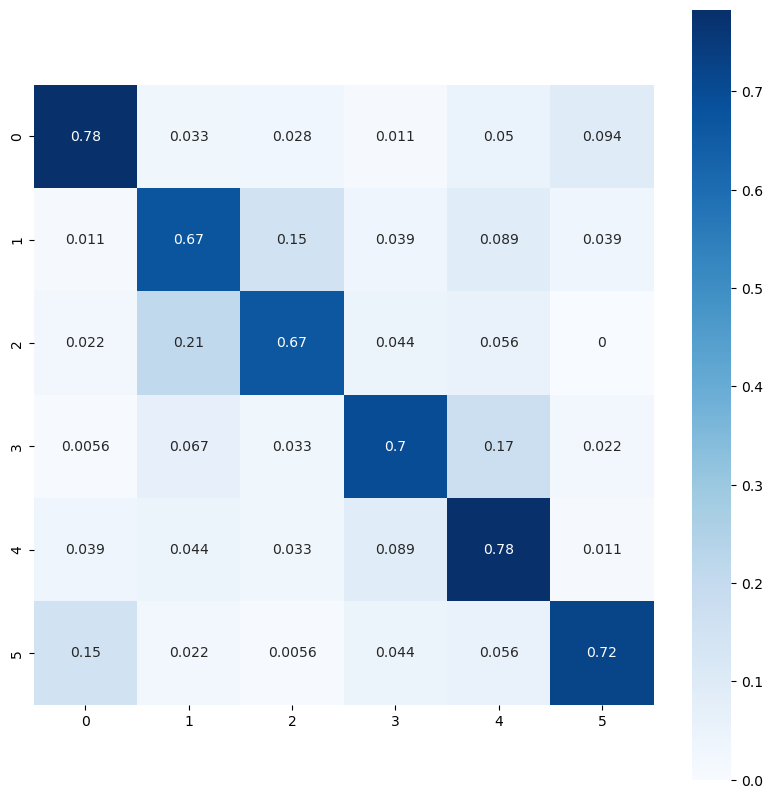

In [58]:
# create the best model
best_model = Sequential(
    [
        ConvBlock(
            filters=best_params["conv1_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_1",
        ),
        ConvBlock(
            filters=best_params["conv2_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_2",
        ),
        ConvBlock(
            filters=best_params["conv3_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_3",
        ),
        ConvBlock(
            filters=best_params["conv4_filters"],
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            pool_size=(2, 2),
            pool_strides=(2, 2),
            pool_padding="valid",
            activation="relu",
            name="conv_block_4",
        ),
        Dropout(best_params["dropout"]),
        Flatten(),
        Dense(best_params["dense"], activation="relu"),
        Dense(6, activation="sigmoid"),
    ]
)

# compile the best model
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# train the best model
history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stopping],
)

# evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# seaborn confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
labels = CLASES.keys()
sns.heatmap(
    cm, annot=True, square=True, cmap="Blues", xticklabels=labels, yticklabels=labels
)

# save the best model with timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
best_model.save(f"./models/{timestamp}_best_model.h5")

# Model Evaluation


In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import load_model

custom_objects = {"ConvBlock": ConvBlock}
baseline_model = load_model("./models/base_model.h5", custom_objects=custom_objects)


# evaluate the baseline model
loss, accuracy = baseline_model.evaluate(X_test, y_test)
y_pred = baseline_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# seaborn confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))

TypeError: ConvBlock.__init__() missing 8 required positional arguments: 'filters', 'kernel_size', 'strides', 'padding', 'pool_size', 'pool_strides', 'pool_padding', and 'activation'

In [ ]:
'conv_block_1': ConvBlock(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(
    2, 2), pool_strides=(2, 2), pool_padding='valid', activation='relu'),
'conv_block_2': ConvBlock(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(
    2, 2), pool_strides=(2, 2), pool_padding='valid', activation='relu'),
'conv_block_3': ConvBlock(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(
    2, 2), pool_strides=(2, 2), pool_padding='valid', activation='relu'),
'conv_block_4': ConvBlock(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(
    2, 2), pool_strides=(2, 2), pool_padding='valid', activation='relu'),
